# Downloads


In [7]:
!pip install gym

In [8]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from google.colab import widgets
import time

#Deterministic Environment

In [10]:
class DeterministicEnv(gym.Env):
  metadata = {'render.modes':[]}
  def __init__(self):
    self.table_dim = 6
    self.observation_space = spaces.Discrete(self.table_dim*self.table_dim)
    self.action_space = spaces.Discrete(4)
    self.maxtimesteps=15 #change
    self.rewardStates = dict()

    for i in range(self.table_dim):
      for j in range(self.table_dim):
        self.rewardStates[(i,j)] = -0.05

    t=0.1
    for j in range(self.table_dim):
      self.rewardStates[(0,j)] = t
      t+=0.1
    for i in range(1,self.table_dim):
      self.rewardStates[(i,self.table_dim-1)] = t
      t+=0.05

    self.rewardStates[(self.table_dim-1,self.table_dim-1)] = 1

    # Print reward map
    print(self.rewardStates)
    for i in range(6):
      print("")
      for j in range(6):
        print(str(self.rewardStates[(i,j)]),end=" ")


  def reset(self):
    self.timesteps = 0
    self.agent_pos = [0,0]
    self.goal_pos = [self.table_dim-1,self.table_dim-1]
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    return self.agent_pos



  def step(self,action):
    self.state = np.random.choice(self.observation_space.n)

    if action == 0: #down
      self.agent_pos[0] +=1
    elif action==1: #up
      self.agent_pos[0] -=1
    elif action==2:#right
      self.agent_pos[1] += 1
    elif action==3: #left
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos,0,self.table_dim-1)
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    reward = 0
    if tuple(self.agent_pos) in self.rewardStates: #Checking if agent is in reward position
      reward = self.rewardStates[tuple(self.agent_pos)]

    self.timesteps +=1
    done = False
    if (self.timesteps >= self.maxtimesteps) or (tuple(self.agent_pos) == tuple(self.goal_pos)):#Ensuring Safety in AI
      done = True 
    info = {}

    return self.agent_pos, reward, done, info



  def render(self):
    plt.imshow(self.state)

In [11]:
DeterministicEnv()

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 1}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 1 

# DQN

In [12]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(*input_dims,self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
      layer1 = F.relu(self.fc1(state.float()))
      layer2 = F.relu(self.fc2(layer1))
      actions = self.fc3(layer2)

      return actions

# Q-Learning Agent

In [15]:
class QlearningAgent:
    # def __init__(self, env,epsilon=1.0,lr=0.6,gamma=0.9):
    def __init__(self, env,input_dims,n_actions,epsilon=1.0,lr=0.6,gamma=0.9,batch_size=300,max_mem_size=1000,C=10):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        # q_table_dim = env.table_dim

        # self.q_table = np.zeros((q_table_dim,q_table_dim,env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

        self.batch_size = batch_size
        self.max_mem_size=max_mem_size
        self.tracker = 0

        self.Q_eval = DeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=64,fc2_dims=128) #change
        self.Q_eval_hat = DeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=64,fc2_dims=128) #change
        self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())
        self.cnt=0

        self.state_memory = np.zeros((self.max_mem_size,*input_dims),dtype=np.float)
        self.new_state_memory = np.zeros((self.max_mem_size,*input_dims),dtype=np.float)

        self.action_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.reward_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype=np.bool)

        self.C = C

    def step(self,observation):

      if random.uniform(0,1)<self.epsilon:
        action = np.random.choice(self.action_space.n)
        return action
      else:
      #  Ask Neural Network
        state = T.tensor([observation]).to(self.Q_eval.device)
        x = self.Q_eval.forward(state)
        # return np.argmax(self.q_table[int(observation[0]),int(observation[1])])
        return int(T.argmax(x))
    
    def store(self,state,action,reward,next_state,done):
     # Storing Code starts
      index = self.cnt%self.max_mem_size
      self.state_memory[index] = state
      self.new_state_memory[index] = next_state
      self.action_memory[index] = action
      self.reward_memory[index] = reward
      self.terminal_memory[index] = done
      # Storing Code Ends
    def setEpsilon(self,epsilon):
      self.epsilon = epsilon

    def learn(self):
          #New Code Starts

          self.cnt+=1
          if self.cnt<self.batch_size:
            return
          mem = min(self.cnt,self.max_mem_size)
          batch = np.random.choice(mem,self.batch_size,replace=False)

          # print(batch)
          for index in batch:
            self.Q_eval.optimizer.zero_grad()
            # q_update = self.reward_memory[index]
            q_update = T.tensor(float(self.reward_memory[index])).to(self.Q_eval.device)
            if not self.terminal_memory[index]:
              next_state_batch=T.tensor(self.new_state_memory[index]).to(self.Q_eval.device)     
              q_next = self.Q_eval_hat.forward(next_state_batch)

              q_update = self.reward_memory[index] + self.gamma*T.max(q_next)

            state_batch=T.tensor(self.state_memory[index]).to(self.Q_eval.device)
            q_val = self.Q_eval.forward(state_batch)
            # q_val[int(self.action_memory[index])] = float(q_update)

            q_update.detach()
            loss = self.Q_eval.loss(q_update,q_val)
            loss.backward()
            self.Q_eval.optimizer.step()
          
          if self.cnt%self.C==0:
            self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())


# Q-Learning Deterministic

In [16]:
# setting up environment and agent
env = DeterministicEnv()
agent = QlearningAgent(env=env,input_dims=[2],n_actions=4,epsilon=1.0,lr=0.001,gamma=0.95,batch_size=200,max_mem_size=1000,C=5)
# agent = QlearningAgent(env,batch_size=64)
# agent = Agent(gamma=0.99,epsilon=1.0,batch_size=64,n_actions=4,
#               eps_end=0.01,input_dims=[8], lr=0.003)
episodes = 500
min_epsilon = 0.1

q_d_epsilons = []
q_d_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False
  q_d_epsilons.append(agent.epsilon)

  curr_reward = 0
  print(episode)
  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    # agent.update(state,action,reward,next_state)
    agent.store(state,action,reward,next_state,done)
    agent.learn()

  q_d_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.999)
  agent.setEpsilon(epsilon)

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 1}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 1 0
1
2
3
4
5
6
7
8
9
10
11
12
13


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
28

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 1}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 1 

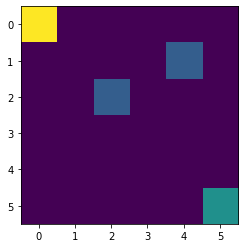

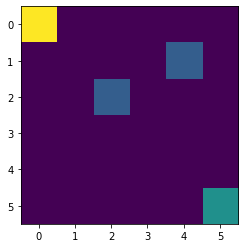

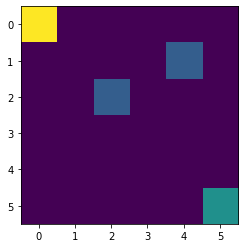

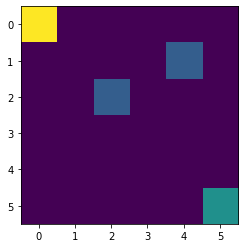

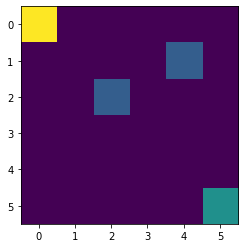

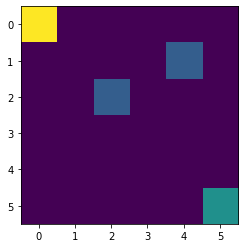

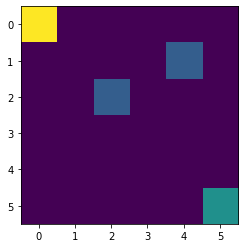

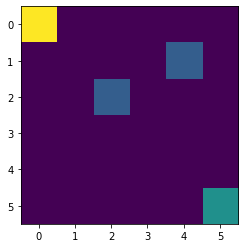

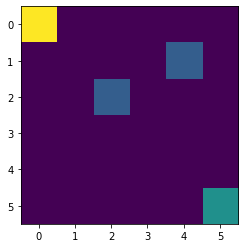

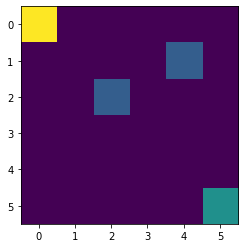

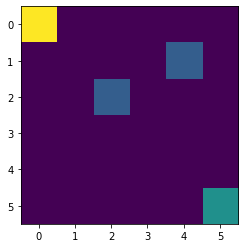

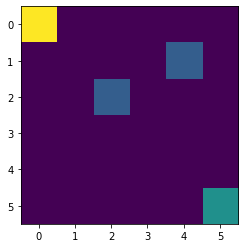

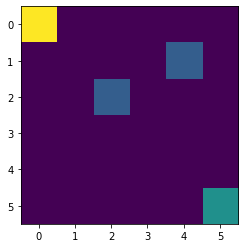

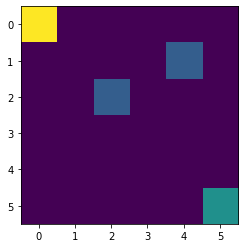

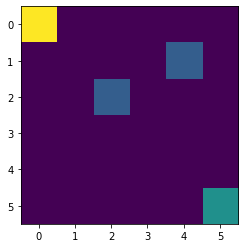

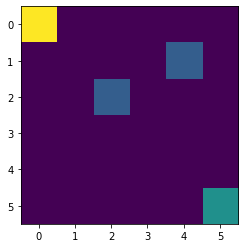

In [17]:
env = DeterministicEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

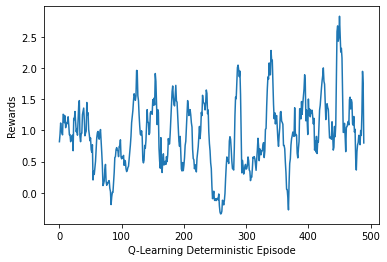

In [18]:
window = 10
plt.xlabel('DQ-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])

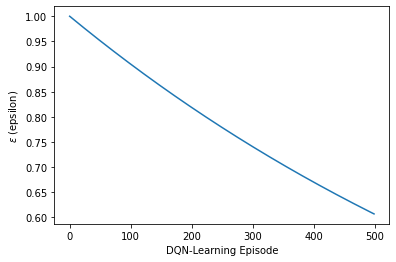

In [19]:
plt.xlabel('DQN-Learning Episode')
plt.ylabel('$\epsilon$ (epsilon)')
plt.plot(q_d_epsilons)